In [ ]:
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import random
import community

In [89]:
res_file = "data"
prefix = "all"

edges = pd.read_csv(os.path.join(res_file,"worldwide_se_edges.csv"),index_col = 0)
edges.head()

,ID_x,Sex_x,ID_y,Sex_y
2120,1,male,2120,female
3174,3,male,3174,male
2641,5,female,2641,female
3024,6,male,3024,female
284,8,male,284,male


In [90]:
len(edges)

14660

## Percentage of Men and Women

In [91]:
edges

,ID_x,Sex_x,ID_y,Sex_y
2120,1,male,2120,female
3174,3,male,3174,male
2641,5,female,2641,female
3024,6,male,3024,female
284,8,male,284,male
...,...,...,...,...
2908,3664,male,2908,male
2996,3664,male,2996,male
3203,3664,male,3203,male
3206,3664,male,3206,male


In [92]:
def makegraph(edges):
    nodes = edges[['ID_x','Sex_x']].drop_duplicates().set_index('ID_x',drop=True)
    graph = nx.from_pandas_edgelist(edges, source='ID_x', target='ID_y')
    nx.set_node_attributes(graph, pd.Series(nodes.Sex_x, index=nodes.index).to_dict(), 'sex')

    return graph

def clustering_coefficient(graph):
    return pd.DataFrame( nx.clustering(graph), index=[0] ).T.reset_index().rename(columns={'index':'node',0:'clustering_coeff'})

## Homophily

In [93]:
G = makegraph(edges)

In [94]:
len(G)

2445

In [95]:
nodes_without_desired_attribute = []

# Iterate through the nodes of the graph
for node in G.nodes():
    # Check if the node has the desired attribute
    if "sex" not in G.nodes[node]:
        nodes_without_desired_attribute.append(node)

G.remove_nodes_from(nodes_without_desired_attribute)

In [96]:
len(G)

2043

In [97]:
men = [node for node in G.nodes() if 'sex' in G.nodes[node] and G.nodes[node]['sex'] == 'male']
women = [node for node in G.nodes() if 'sex' in G.nodes[node] and G.nodes[node]['sex'] == 'female']

print(len(men))
print(len(women))

1708
335


In [98]:
p = len(men)/(len(men) + len(women))
q = len(women)/(len(men) + len(women))

In [99]:
men_men_edges = []
women_women_edges = []
cross_edges = []

# Iterate through the edges of the graph
for u, v in G.edges():
    # Check the attributes of the nodes at the endpoints
    if G.nodes[u]["sex"] == 'male' and G.nodes[v]["sex"] == 'male':
        men_men_edges.append((u, v))

    if G.nodes[u]["sex"] == 'female' and G.nodes[v]["sex"] == 'female':
        women_women_edges.append((u, v))

    if G.nodes[u]["sex"] == 'female' and G.nodes[v]["sex"] == 'male':
        cross_edges.append((u, v))

    if G.nodes[u]["sex"] == 'male' and G.nodes[v]["sex"] == 'female':
        cross_edges.append((u, v))

In [100]:
len( cross_edges ) / len( G.edges() )

0.2713239436619718

In [101]:
2*p*q

0.2741737901874265

In [102]:
( len( cross_edges ) / len( G.edges() ) ) / (2*p*q)

0.9896056930769841

## Clustering Coefficient

We compute the Clustering Coefficient for three different graphs: the total one, the one composed only of women, and the one composed only of men.

In [103]:
css = pd.DataFrame()
for i in range(10):
    #add clustering coefficient to css
    sampled_nodes = random.sample( list( G.edge_subgraph(men_men_edges).nodes ), len(women))
    css = pd.concat([css, clustering_coefficient ( G.edge_subgraph(men_men_edges).subgraph(sampled_nodes) )], axis=1)    

    #remove columns named "node"
    css = css.drop(columns=['node'])

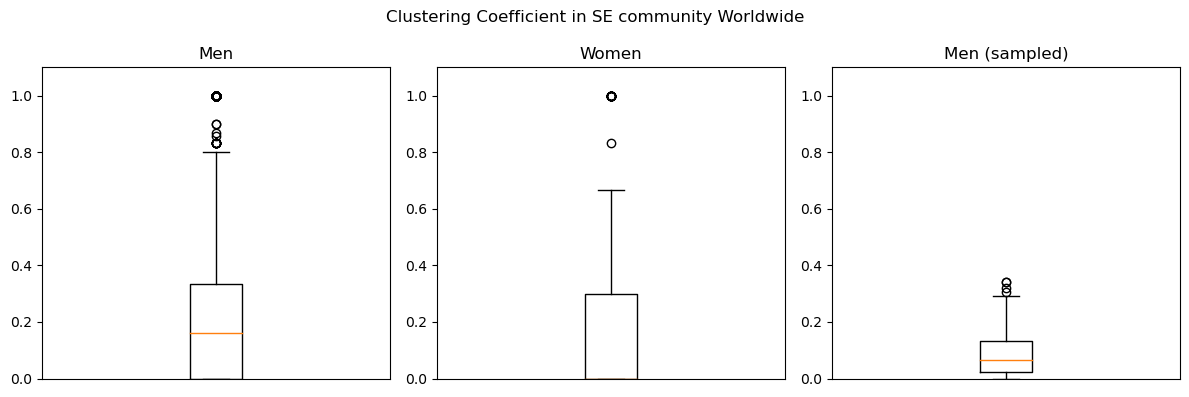

In [104]:
fig, ( (ax_one,ax_two,ax_three)) = plt.subplots(nrows=1,ncols=3)
axes= [ax_one,ax_two,ax_three]

fig = plt.gcf()
fig.set_size_inches(12,4)

axes[0].boxplot(clustering_coefficient(G.edge_subgraph(men_men_edges))['clustering_coeff'])
axes[0].set_title("Men")

axes[1].boxplot(clustering_coefficient(G.edge_subgraph(women_women_edges))['clustering_coeff'])
axes[1].set_title("Women")

axes[2].boxplot( css.mean(axis=1) )
axes[2].set_title("Men (sampled)")


for ax in axes:
    ax.set_ylim(0,1.1)
    ax.set_xlabel('')
    ax.set_xticks([])

fig.suptitle("Clustering Coefficient in SE community Worldwide")


fig.tight_layout()
plt.show()

In [105]:
from scipy import stats

# Sample data for clustering coefficients of types A and B
data_A = clustering_coefficient(G.edge_subgraph(men_men_edges))['clustering_coeff']
data_B = clustering_coefficient(G.edge_subgraph(women_women_edges))['clustering_coeff']

# Perform a Mann-Whitney U test
U_statistic, p_value = stats.mannwhitneyu(data_A, data_B, alternative='two-sided')

print(p_value)
# Check the p-value to determine if the difference is statistically significant
if p_value < 0.05:
    print("The difference is statistically significant.")
else:
    print("The difference is not statistically significant.")

7.772945268703275e-06
The difference is statistically significant.


In [106]:
alpha = 0.05  # 95% confidence level
z = stats.norm.ppf(1 - alpha / 2)
n_A = len(data_A)
n_B = len(data_B)
# Calculate the standard error of U
se_U = np.sqrt(n_A * n_B * (n_A + n_B + 1) / 12)

# Calculate the lower and upper bounds of the confidence interval
lower_bound = U_statistic - z * se_U
upper_bound = U_statistic + z * se_U

print("Mann-Whitney U Statistic:", U_statistic)
print("95% Confidence Interval:", (lower_bound, upper_bound))

Mann-Whitney U Statistic: 189157.0
95% Confidence Interval: (175711.67431558212, 202602.32568441788)


## Community detection

In [107]:
men_graph = G.edge_subgraph(men_men_edges)
women_graph = G.edge_subgraph(women_women_edges)

In [108]:
# Apply Louvain community detection separately for types A and B
communities_men = community.best_partition(men_graph)
communities_women = community.best_partition(women_graph)

# Calculate and normalize modularity for A and B
modularity_men = community.modularity(communities_men, men_graph) / len(men_graph.nodes)
modularity_women = community.modularity(communities_women, women_graph) / len(women_graph.nodes)

# Print or analyze the normalized modularity values for comparison
print(f"Normalized Modularity for men: {modularity_men}")
print(f"Normalized Modularity for women: {modularity_women}")

Normalized Modularity for men: 0.00034854445461160905
Normalized Modularity for women: 0.0034388729086422634


# Italy

In [109]:
prefix = "ita"

edges = pd.read_csv(os.path.join(res_file,"italian_se_edges.csv"),index_col = 0)
edges.head()

,Sex_x,Sex_y,ID_x,ID_y
0,male,male,59,48
1,male,male,1,48
2,male,male,33,48
3,male,male,52,48
4,male,male,49,48


In [110]:
G = makegraph(edges)

nodes_without_desired_attribute = []

# Iterate through the nodes of the graph
for node in G.nodes():
    # Check if the node has the desired attribute
    if "sex" not in G.nodes[node]:
        nodes_without_desired_attribute.append(node)

G.remove_nodes_from(nodes_without_desired_attribute)

In [111]:
men = [node for node in G.nodes() if 'sex' in G.nodes[node] and G.nodes[node]['sex'] == 'male']
women = [node for node in G.nodes() if 'sex' in G.nodes[node] and G.nodes[node]['sex'] == 'female']

print(len(men))
print(len(women))

63
19


In [112]:
p = len(men)/(len(men) + len(women))
q = len(women)/(len(men) + len(women))

In [113]:
men_men_edges = []
women_women_edges = []
cross_edges = []

# Iterate through the edges of the graph
for u, v in G.edges():
    # Check the attributes of the nodes at the endpoints
    if G.nodes[u]["sex"] == 'male' and G.nodes[v]["sex"] == 'male':
        men_men_edges.append((u, v))

    if G.nodes[u]["sex"] == 'female' and G.nodes[v]["sex"] == 'female':
        women_women_edges.append((u, v))

    if G.nodes[u]["sex"] == 'female' and G.nodes[v]["sex"] == 'male':
        cross_edges.append((u, v))

    if G.nodes[u]["sex"] == 'male' and G.nodes[v]["sex"] == 'female':
        cross_edges.append((u, v))

In [114]:
len( cross_edges ) / len( G.edges() )

0.4055299539170507

In [115]:
2*p*q

0.35603807257584774

In [116]:
css = pd.DataFrame()
for i in range(10):
    #add clustering coefficient to css
    sampled_nodes = random.sample( list( G.edge_subgraph(men_men_edges).nodes ), len(women))
    css = pd.concat([css, clustering_coefficient ( G.edge_subgraph(men_men_edges).subgraph(sampled_nodes) )], axis=1)    

    #remove columns named "node"
    css = css.drop(columns=['node'])

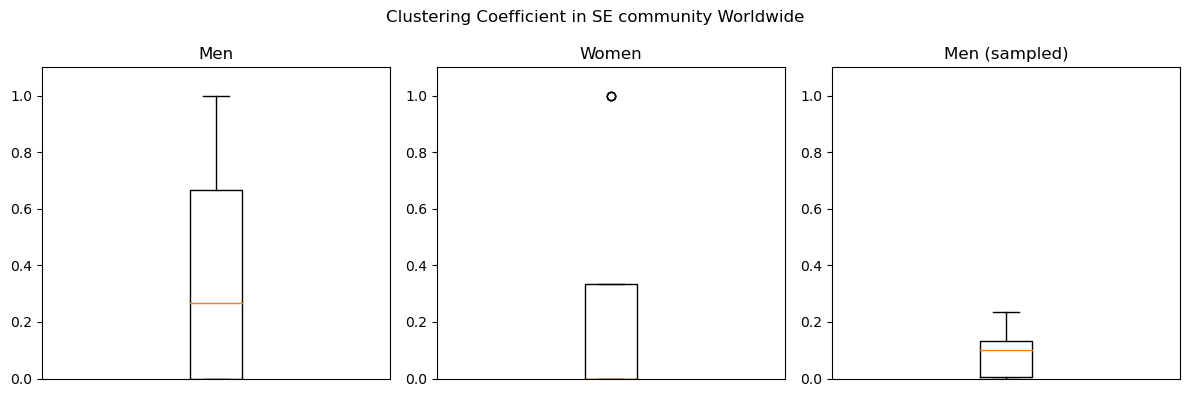

In [117]:
fig, ( (ax_one,ax_two,ax_three)) = plt.subplots(nrows=1,ncols=3)
axes= [ax_one,ax_two,ax_three]

fig = plt.gcf()
fig.set_size_inches(12,4)

axes[0].boxplot(clustering_coefficient(G.edge_subgraph(men_men_edges))['clustering_coeff'])
axes[0].set_title("Men")

axes[1].boxplot(clustering_coefficient(G.edge_subgraph(women_women_edges))['clustering_coeff'])
axes[1].set_title("Women")

axes[2].boxplot( css.mean(axis=1) )
axes[2].set_title("Men (sampled)")


for ax in axes:
    ax.set_ylim(0,1.1)
    ax.set_xlabel('')
    ax.set_xticks([])

fig.suptitle("Clustering Coefficient in SE community Worldwide")


fig.tight_layout()
plt.show()

In [118]:
men_graph = G.edge_subgraph(men_men_edges)
women_graph = G.edge_subgraph(women_women_edges)

In [119]:
# Apply Louvain community detection separately for types A and B
communities_men = community.best_partition(men_graph)
communities_women = community.best_partition(women_graph)

# Calculate and normalize modularity for A and B
modularity_men = community.modularity(communities_men, men_graph) / len(men_graph.nodes)
modularity_women = community.modularity(communities_women, women_graph) / len(women_graph.nodes)

# Print or analyze the normalized modularity values for comparison
print(f"Normalized Modularity for men: {modularity_men}")
print(f"Normalized Modularity for women: {modularity_women}")

Normalized Modularity for men: 0.009960085196088373
Normalized Modularity for women: 0.03567708333333333
